# Clustering Argo profiles using a Profile Classification Model (PCM; Maze et al., 2017)

### Import some libraries

In [1]:
import os,sys
import numpy as np
import netCDF4 as nc

import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import interpolate

from datetime import datetime

# run clustering algorithms for T/S, using PCA as dimension reduction
from sklearn import preprocessing#, mixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split

# import colormaps
from palettable.colorbrewer.qualitative import Accent_4 as acc
from palettable.colorbrewer.qualitative import Accent_5 as acc5
from palettable.colorbrewer.qualitative import Paired_4 as paired

from load_folders import fold_paths
fold_paths()

# import cm colorbars
sys.path.append(fold_paths.cmocean)
import cm

# import gsw library
sys.path.append(fold_paths.gsw)
import gsw

# import modules for PCM
sys.path.append(fold_paths.classification)
import run_PCM
import plot_maps

plotdir     = fold_paths.plotdir
ETOPO       = fold_paths.ETOPO
floatdir    = fold_paths.floatdir
dirRdm      = fold_paths.dirRdm
folder_argo = fold_paths.folder_argo

/Users/Isa/anaconda/envs/isa_env_2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1078: UserWarning: Illegal line #1
	"$ cat ~/.matplotlib/matplotlibrc
"
	in file "/Users/Isa/.matplotlib/matplotlibrc"
  warnings.warn('Illegal %s' % error_details)


In [2]:
run_argo    = False
comp_rdm    = False
tt_split    = False

### Load bathymetry data (from ETOPO) for the Indian sector of the Southern Ocean

In [3]:
data        = nc.Dataset(ETOPO)

XC          = data.variables['x'][:]
YC          = data.variables['y'][:]
bathy       = data.variables['z'][:]
bathy       = np.ma.masked_greater(bathy,0.)
bathy       = -bathy
v           = np.linspace(0,6,7)
x1          = np.min(np.where(XC>=0))
x2          = np.min(np.where(XC>=180))
y1          = np.min(np.where(YC>=-70))
y2          = np.min(np.where(YC>=-30))
# labels for plotting
xtix        = np.linspace(0,180,7)
xtix_l      = ['0']+['%iE'%(int(ii)) for ii in xtix[1:-1]]+['180']
ytix        = np.linspace(-70,-30,9)
ytix_l      = ['%iS'%(int(np.abs(ii))) for ii in ytix]
# new pressure array
press       = np.arange(2,2002,1)

bathy_data  = [XC,YC,bathy,x1,x2,y1,y2,xtix,xtix_l,ytix,ytix_l]

## Run the PCM

In [4]:
# number of clusters
K           = 9

### 1. Load Argo profiles

In [5]:
######################## TRAIN and PREDICT ARGO ########################
filePT  = os.path.join(folder_argo,'PT_dataSO.npz')
fileSA  = os.path.join(folder_argo,'SA_dataSO.npz')
fileSP  = os.path.join(folder_argo,'SP_dataSO.npz')
fileS0  = os.path.join(folder_argo,'dens_dataSO.npz')
fileID  = os.path.join(folder_argo,'IDSO.npz')
fileLON = os.path.join(folder_argo,'lon_dataSO.npz')
fileLAT = os.path.join(folder_argo,'lat_dataSO.npz')
fileYY  = os.path.join(folder_argo,'years_dataSO.npz')
if run_argo:
    # load the profiles     
    sys.path.append(fold_paths.classification)
    import load_profiles
    # if making some changes to the module, while running the kernel, reload the module:
    #import imp
    #imp.reload(load_profiles)

    # load the Argo profiles
    [profSO, temporalSO] = load_profiles.IO_argo(floatdir)
    
    # all depth profiles
    PT_dataSO  = profSO[0]
    SA_dataSO  = profSO[1]
    lon_dataSO = profSO[2]
    lat_dataSO = profSO[3]
    IDSO       = profSO[4]
    # years
    years_dataSO = temporalSO[0]

    # chop between 300 m and 1000 m.. more or less. There should be all numbers, and no Nans...
    # trying with only a subset (in vertical) of the profiles
    # First search for those floats that have Nans Between 200 and 1200 m
    id1,id2    = np.where(np.isnan(PT_dataSO[:,198:1199]))

    # then, remove the floats where the first not NaN value is deeper than 300 or the deepest is shallower than 900 m
    idBadNew   = []
    for ii in np.unique(id1):
        if not(press[np.min(np.where(~np.isnan(PT_dataSO[ii,:])))]<=300. and press[np.max(np.where(~np.isnan(PT_dataSO[ii,:])))]>=900):
            idBadNew.append(ii)
    PT_dataSO  = np.delete(PT_dataSO,idBadNew,0)
    SA_dataSO  = np.delete(SA_dataSO,idBadNew,0)
    IDSO       = np.delete(IDSO,idBadNew,0)
    lon_dataSO = np.delete(lon_dataSO,idBadNew,0)
    lat_dataSO = np.delete(lat_dataSO,idBadNew,0)
    years_dataSO= np.delete(years_dataSO,idBadNew,0)

    # sigma_theta (from Absolute Salinity and Conservative Temperature!!)
    CT_dataSO    = gsw.CT_from_pt(SA_dataSO, PT_dataSO)
    dens_dataSO  = gsw.sigma0(SA_dataSO,CT_dataSO)

    # save compressed files:
    np.savez_compressed(filePT, PT_dataSO=PT_dataSO)
    np.savez_compressed(fileSA, SA_dataSO=SA_dataSO)
    np.savez_compressed(fileS0, dens_dataSO=dens_dataSO)
    np.savez_compressed(fileID, IDSO=IDSO)
    np.savez_compressed(fileLON, lon_dataSO=lon_dataSO)
    np.savez_compressed(fileLAT, lat_dataSO=lat_dataSO)
    np.savez_compressed(fileYY,years_dataSO=years_dataSO)
else:
    # load compressed files
    PT_dataSO  = np.load(filePT)['PT_dataSO']
    SA_dataSO  = np.load(fileSA)['SA_dataSO']
    SP_dataSO  = np.load(fileSP)['SP_dataSO']
    dens_dataSO= np.load(fileS0)['dens_dataSO']
    IDSO       = np.load(fileID)['IDSO']
    lon_dataSO = np.load(fileLON)['lon_dataSO']
    lat_dataSO = np.load(fileLAT)['lat_dataSO']
    years_dataSO = np.load(fileYY)['years_dataSO']

### 2. Fit the scaler object between 300 and 900 m, in order to standardize dataset by removing the mean and scaling to unit variance:


In [6]:
idz1      = np.min(np.where(press>=300.))
idz2      = np.min(np.where(press>=900.))
scalerPT  = preprocessing.StandardScaler()
scalerPT  = scalerPT.fit(PT_dataSO[:,idz1:idz2])
scalerSA  = preprocessing.StandardScaler()
scalerSA  = scalerSA.fit(SA_dataSO[:,idz1:idz2])
scalerSP  = preprocessing.StandardScaler()
scalerSP  = scalerSP.fit(SP_dataSO[:,idz1:idz2])

# remove entire columns of NaNs
PT_dataSO[np.where(SA_dataSO<33)]= np.nan
SA_dataSO[np.where(SA_dataSO<33)]= np.nan
idBad  = []
for ii in range(SA_dataSO.shape[0]):
    f0 = SA_dataSO[ii,:]
    f1 = f0[~np.isnan(f0)]
    if len(f1) == 0:
        idBad.append(ii)
PT_dataSO  = np.delete(PT_dataSO,idBad,0)
SA_dataSO  = np.delete(SA_dataSO,idBad,0)
SP_dataSO  = np.delete(SA_dataSO,idBad,0)
lon_dataSO = np.delete(lon_dataSO,idBad,0)
lat_dataSO = np.delete(lat_dataSO,idBad,0)
dens_dataSO= np.delete(dens_dataSO,idBad,0)
IDSO       = np.delete(IDSO,idBad,0)
years_dataSO = np.delete(years_dataSO,idBad,0)

# Mean and std profiles for the chopped profiles:
mean_PT   = scalerPT.mean_
std_PT    = scalerPT.scale_
mean_SA   = scalerSA.mean_
std_SA    = scalerSA.scale_
mean_SP   = scalerSP.mean_
std_SP    = scalerSP.scale_

# Normalize the chopped profiles
PTn       = scalerPT.transform(PT_dataSO[:,idz1:idz2])
SAn       = scalerSA.transform(SA_dataSO[:,idz1:idz2])

# take only the training set
if tt_split:
    # Can use the train_test_split() function, but this does not assure that we'll have a coherent distribution.
    # better to randomly select a profile every XX deg x YY deg (see after)
    X       = PT_dataSO[:,100]
    y       = range(len(X))
    X_train, X_test, rdm, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    rdm     = np.array(rdm)
else:
    # randomly select a profile every 0.1 deg x 0.1 deg
    outfileRdm = os.path.join(dirRdm,'random_89percent.npz')
    if comp_rdm:
        rdm = []
        degRdm = 0.1
        for ix in np.arange(0,180,degRdm):
            for iy in np.arange(-70,-30,degRdm):
                idx = np.where(np.logical_and(np.logical_and(np.logical_and(lon_dataSO>=ix,lon_dataSO<ix+degRdm),lat_dataSO>=iy),lat_dataSO<iy+degRdm))[0][:]
                try:
                    tmp = np.random.choice(idx,1)
                    rdm = np.append(rdm,tmp)
                except:
                    print 'no Argo in %.1fiE-%.1fE, %.1fS-%.1fS' %(ix,ix+degRdm,iy,iy+degRdm)

        rdm  = np.array([int(ii) for ii in rdm])
        np.savez(outfileRdm,rdm)
    else:
        npzfile = np.load(outfileRdm)
        rdm     = npzfile['arr_0']
## to check that it does produce always the same list, run the code twice, plotting the results on top of each other
#plt.scatter(lon_dataSO[rdm],lat_dataSO[rdm],c='c',s=3,edgecolor='None')

PTn_tr  = PTn[rdm,:]
SAn_tr  = SAn[rdm,:]

# Extract mean and std of SA and THETA of the whole profiles
mean_PT_t   = np.nanmean(PT_dataSO,axis=0)
std_PT_t    = np.nanstd(PT_dataSO,axis=0)
mean_SA_t   = np.nanmean(SA_dataSO,axis=0)
std_SA_t    = np.nanstd(SA_dataSO,axis=0)

/Users/Isa/anaconda/envs/isa_env_2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype >f4 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Isa/anaconda/envs/isa_env_2.7/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/Users/Isa/anaconda/envs/isa_env_2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


### 3. Reduce the profiles using the PCA:

The Variance Explained computed by me for all the components is  99.9105368864
The Variance Explained computed by me for the first 2 modes of the original data is  99.7044956831
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.97923605  0.01780899  0.00206033]

We reduced the dimensionality of the problem from 2000 depth levels down to 3 PCs



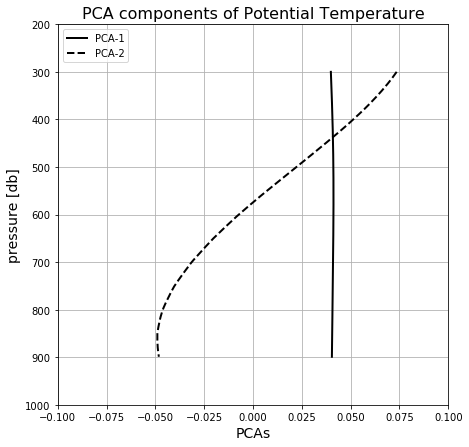

In [7]:
# get the training set
PTtr    = PT_dataSO[rdm,:]
SAtr    = SA_dataSO[rdm,:]

# reduce the training set for the temperature
[Nc_PT,V_PT,EOFs_PT,EOFs_real_PT,PTtr_r,reducerPT] = run_PCM.compute_PCA(PTn_tr,scalerPT,None,1,'Potential Temperature',press[idz1:idz2],plotdir)

The Variance Explained computed by me for all the components is  99.9057223161
The Variance Explained computed by me for the first 2 modes of the original data is  98.6883494211
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  7.97526199e-01   1.89356065e-01   8.59686325e-03   2.03134068e-03
   8.08756298e-04   4.50894822e-04   2.86962825e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 7 PCs



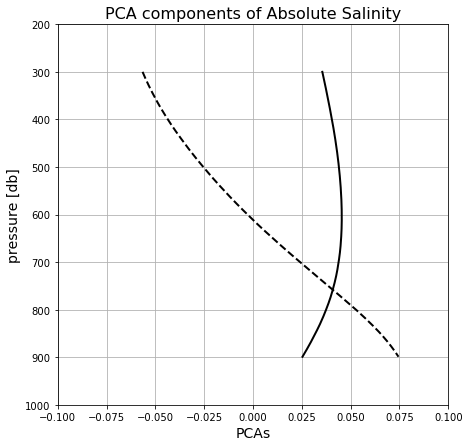

In [8]:
# reduce the training set for the salinity
[Nc_SA,V_SA,EOFs_SA,EOFs_real_SA,SAtr_r,reducerSA] = run_PCM.compute_PCA(SAn_tr,scalerSA,None,1,'Absolute Salinity',press[idz1:idz2],plotdir)

In [9]:
# I don't want to print the output now:
old_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

# reduce the full dataset:
[Nc_PT,V_PT,EOFs_PT,EOFs_real_PT,PT_r,reducerPT]   = run_PCM.compute_PCA(PTn,scalerPT,reducerPT,0,'Potential Temperature',None,plotdir)
[Nc_SA,V_SA,EOFs_SA,EOFs_real_SA,SA_r,reducerSA]   = run_PCM.compute_PCA(SAn,scalerSA,reducerSA,0,'Absolute Salinity',None,plotdir)

# I can start to print out again:
sys.stdout = old_stdout

#### Reduce the original data using the first 2 modes for T and for S:

In [10]:
# 2 PCAs
# training set
setTr_r = np.zeros((PTtr_r.shape[0],4))
setTr_r[...,0] = PTtr_r[:,0]
setTr_r[...,1] = PTtr_r[:,1]
setTr_r[...,2] = SAtr_r[:,0]
setTr_r[...,3] = SAtr_r[:,1]

# full set
set_r = np.zeros((PT_r.shape[0],4))
set_r[...,0] = PT_r[:,0]
set_r[...,1] = PT_r[:,1]
set_r[...,2] = SA_r[:,0]
set_r[...,3] = SA_r[:,1]

#### How much does S add? Compute the cross correlation between the different modes (note: I think that it would be very helpful to check in different regions, because I think the cross correlation is higher in the ACC, where S doesn't add much to the method, but lower in the subtropics and close to Antarctica)

In [11]:
# I can start to print out again:
print 'cross correlation between PCA1_PT and PCA1_SA = ', np.corrcoef(PT_r[:,0],SA_r[:,0])[0,1]
print 'cross correlation between PCA1_PT and PCA2_SA = ', np.corrcoef(PT_r[:,0],SA_r[:,1])[0,1]
print 'cross correlation between PCA2_PT and PCA2_SA = ', np.corrcoef(PT_r[:,1],SA_r[:,1])[0,1]
print 'cross correlation xbetween PCA2_PT and PCA1_SA = ', np.corrcoef(PT_r[:,1],SA_r[:,0])[0,1]

cross correlation between PCA1_PT and PCA1_SA =  0.495576992341
cross correlation between PCA1_PT and PCA2_SA =  -0.751834196025
cross correlation between PCA2_PT and PCA2_SA =  -0.497884093983
cross correlation xbetween PCA2_PT and PCA1_SA =  -0.191816663873


### 4. Plot the Bayesian Information Criterion (BIC)

This criterion is used for model selection among a finite set of models. The model with the lowest BIC is chosen. Another selction criterion is the Akaike Information Criterion (AIC), which is not used here.

Compute the BIC score for the selected model and test it for a range of models 

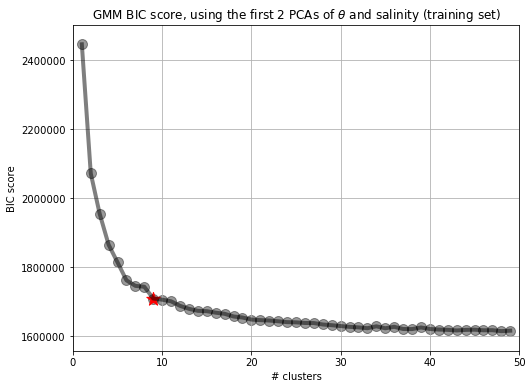

In [12]:
# plot BIC score
run_PCM.plot_BIC(setTr_r,'T_S',K,plotdir)

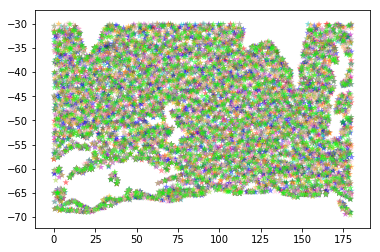

The Variance Explained computed by me for all the components is  99.9378630329
The Variance Explained computed by me for the first 2 modes of the original data is  99.7950368996
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.98571209  0.01223957  0.00142696]

We reduced the dimensionality of the problem from 2000 depth levels down to 3 PCs



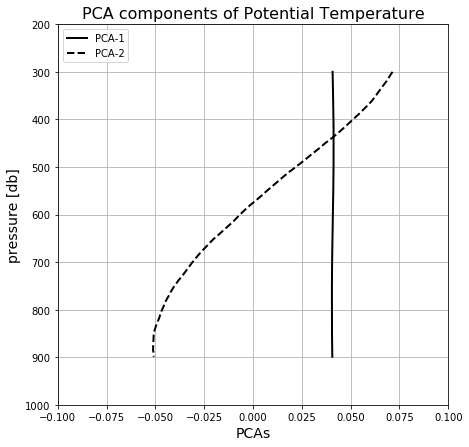

The Variance Explained computed by me for all the components is  99.9261877368
The Variance Explained computed by me for the first 2 modes of the original data is  98.9932390338
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  7.65957051e-01   2.23801070e-01   6.70007107e-03   1.57106332e-03
   5.65878945e-04   3.89060140e-04   2.51450475e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 7 PCs



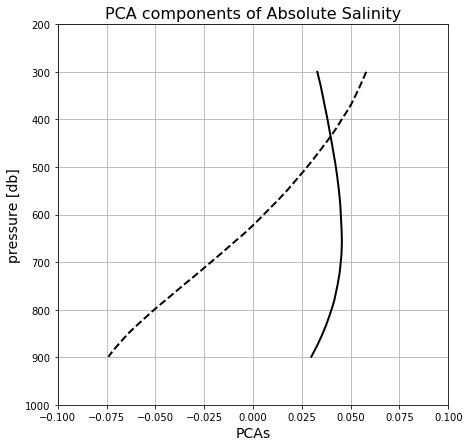

The Variance Explained computed by me for all the components is  99.9356754675
The Variance Explained computed by me for the first 2 modes of the original data is  99.7858322039
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.98606167  0.01180506  0.00149   ]

We reduced the dimensionality of the problem from 2000 depth levels down to 3 PCs



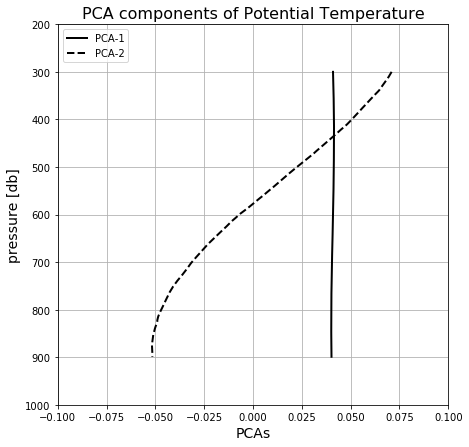

The Variance Explained computed by me for all the components is  99.9058354664
The Variance Explained computed by me for the first 2 modes of the original data is  98.9418807195
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  7.52309006e-01   2.36901998e-01   7.08356865e-03   1.64669779e-03
   6.52009146e-04   4.31598033e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 6 PCs



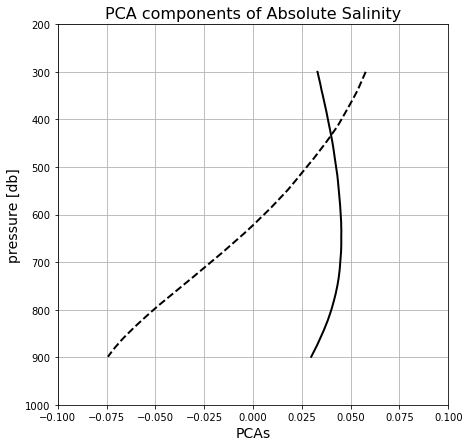

The Variance Explained computed by me for all the components is  99.9313516923
The Variance Explained computed by me for the first 2 modes of the original data is  99.7847420442
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.98528216  0.01257011  0.00146124]

We reduced the dimensionality of the problem from 2000 depth levels down to 3 PCs



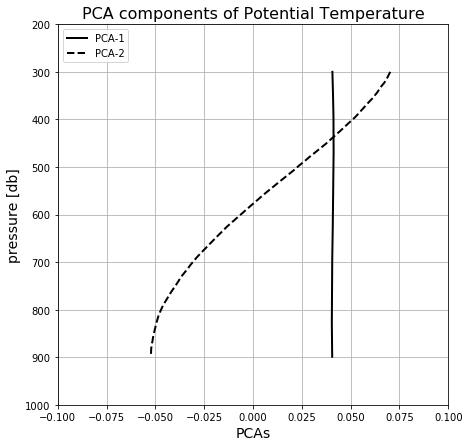

The Variance Explained computed by me for all the components is  99.9123955997
The Variance Explained computed by me for the first 2 modes of the original data is  98.8567717352
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  7.52358423e-01   2.35924104e-01   7.46631558e-03   1.73184591e-03
   8.94981953e-04   4.41779806e-04   2.74696388e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 7 PCs



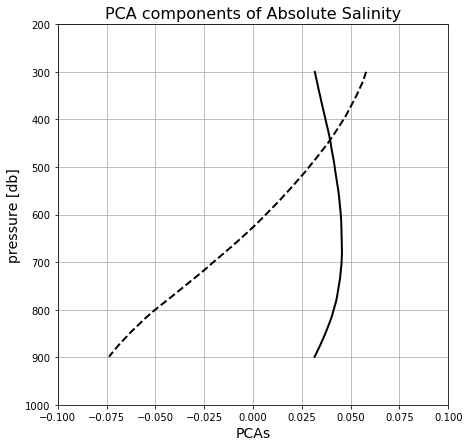

The Variance Explained computed by me for all the components is  99.9411942575
The Variance Explained computed by me for the first 2 modes of the original data is  99.8014137656
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.98641423  0.01160973  0.00138798]

We reduced the dimensionality of the problem from 2000 depth levels down to 3 PCs



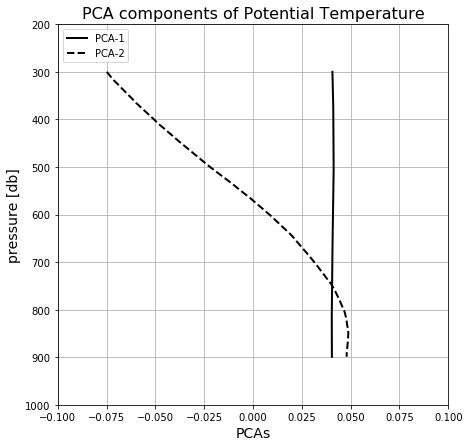

The Variance Explained computed by me for all the components is  99.912204247
The Variance Explained computed by me for the first 2 modes of the original data is  98.9945345814
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  7.66425563e-01   2.23208523e-01   7.01482960e-03   1.44538084e-03
   5.98761605e-04   3.96118875e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 6 PCs



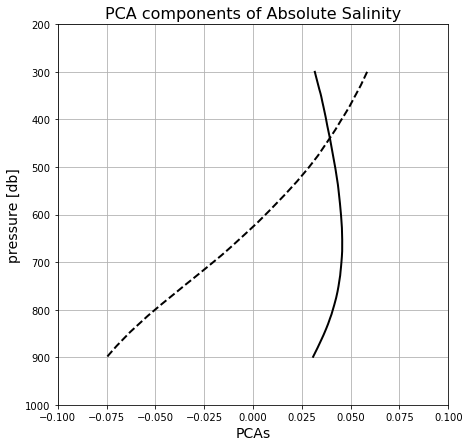

The Variance Explained computed by me for all the components is  99.9330415319
The Variance Explained computed by me for the first 2 modes of the original data is  99.794475542
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.98620892  0.01174085  0.00138063]

We reduced the dimensionality of the problem from 2000 depth levels down to 3 PCs



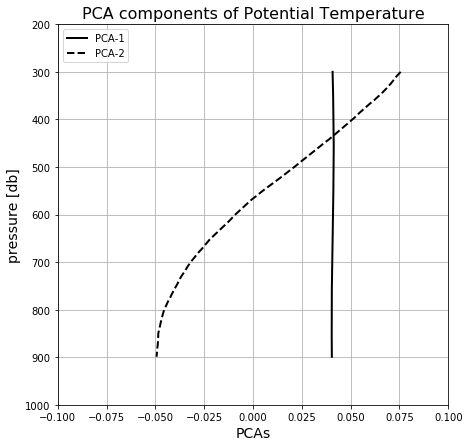

The Variance Explained computed by me for all the components is  99.921822511
The Variance Explained computed by me for the first 2 modes of the original data is  98.9603959825
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  7.66442343e-01   2.22929376e-01   6.94435466e-03   1.60022928e-03
   6.70386832e-04   3.80966686e-04   2.21859999e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 7 PCs



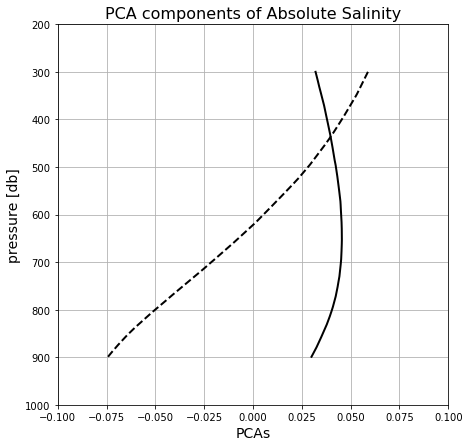

The Variance Explained computed by me for all the components is  99.9352927247
The Variance Explained computed by me for the first 2 modes of the original data is  99.7962407146
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.98571851  0.01225654  0.00137786]

We reduced the dimensionality of the problem from 2000 depth levels down to 3 PCs



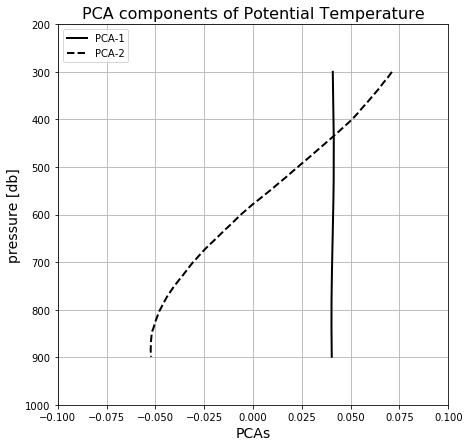

The Variance Explained computed by me for all the components is  99.9247174015
The Variance Explained computed by me for the first 2 modes of the original data is  98.9899284758
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  7.58604914e-01   2.31056704e-01   6.58632350e-03   1.61128463e-03
   7.14407997e-04   4.02522564e-04   2.45903195e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 7 PCs



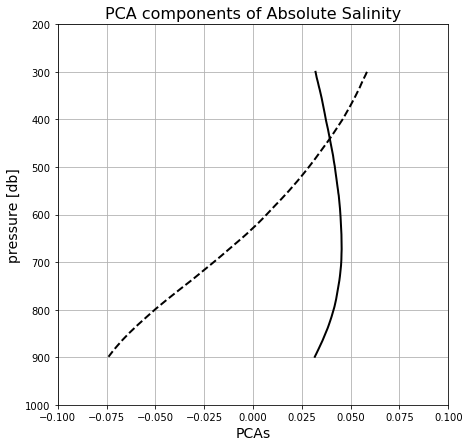

The Variance Explained computed by me for all the components is  99.935269875
The Variance Explained computed by me for the first 2 modes of the original data is  99.7842747347
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.98612881  0.01171894  0.00150495]

We reduced the dimensionality of the problem from 2000 depth levels down to 3 PCs



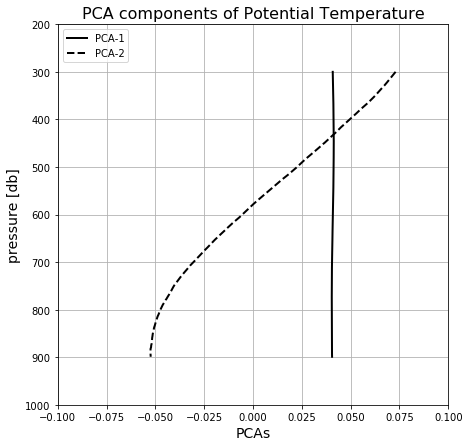

The Variance Explained computed by me for all the components is  99.9237190556
The Variance Explained computed by me for the first 2 modes of the original data is  98.948516785
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  7.56548554e-01   2.32694655e-01   6.78552569e-03   1.78643602e-03
   7.42121038e-04   3.80796257e-04   2.72250154e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 7 PCs



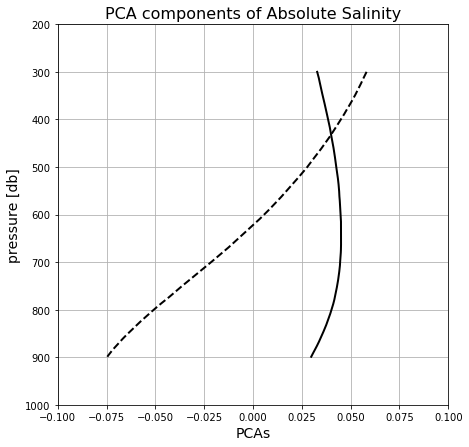

The Variance Explained computed by me for all the components is  99.9381582151
The Variance Explained computed by me for the first 2 modes of the original data is  99.7958060313
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.98628295  0.01167762  0.00142101]

We reduced the dimensionality of the problem from 2000 depth levels down to 3 PCs



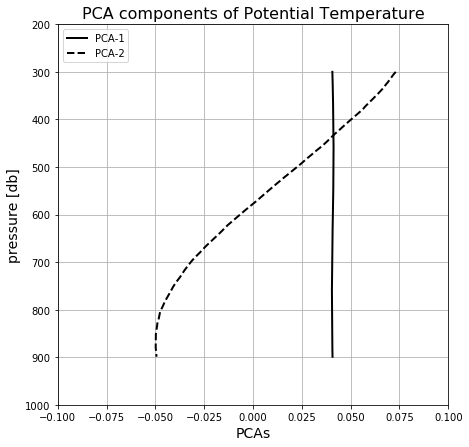

The Variance Explained computed by me for all the components is  99.9206032678
The Variance Explained computed by me for the first 2 modes of the original data is  98.9976420388
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  7.66523607e-01   2.23177481e-01   6.55307213e-03   1.60539006e-03
   6.77422784e-04   3.59509475e-04   2.79032627e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 7 PCs



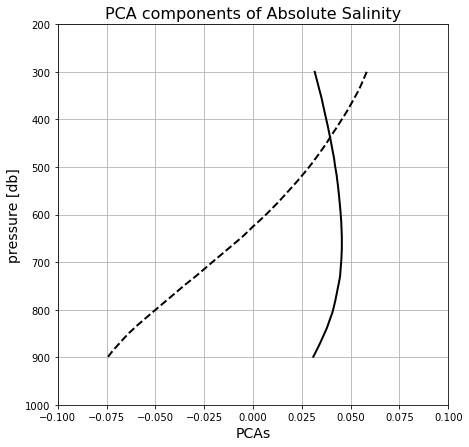

The Variance Explained computed by me for all the components is  99.9312877263
The Variance Explained computed by me for the first 2 modes of the original data is  99.7853777994
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.98560401  0.01225153  0.00145734]

We reduced the dimensionality of the problem from 2000 depth levels down to 3 PCs



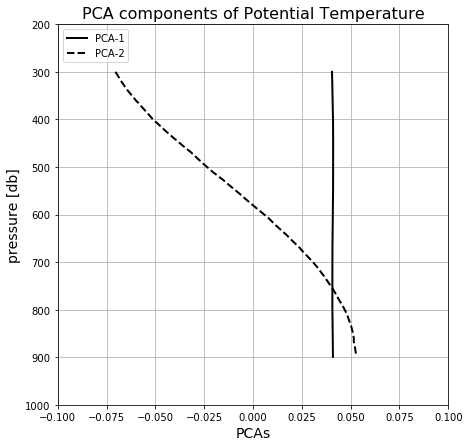

The Variance Explained computed by me for all the components is  99.9204685287
The Variance Explained computed by me for the first 2 modes of the original data is  98.9844086293
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  7.69932486e-01   2.19688814e-01   6.38225618e-03   1.84921842e-03
   6.45594615e-04   3.99038515e-04   2.76927866e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 7 PCs



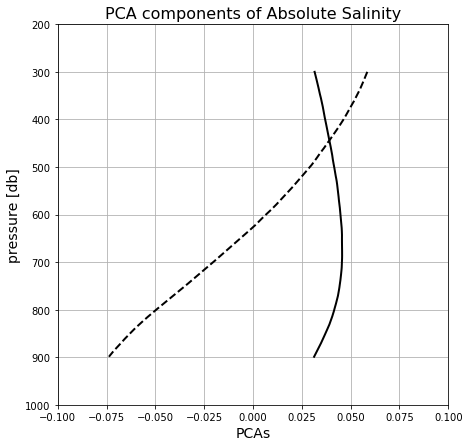

The Variance Explained computed by me for all the components is  99.9355746293
The Variance Explained computed by me for the first 2 modes of the original data is  99.7950546171
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [ 0.98568202  0.01227071  0.00140302]

We reduced the dimensionality of the problem from 2000 depth levels down to 3 PCs



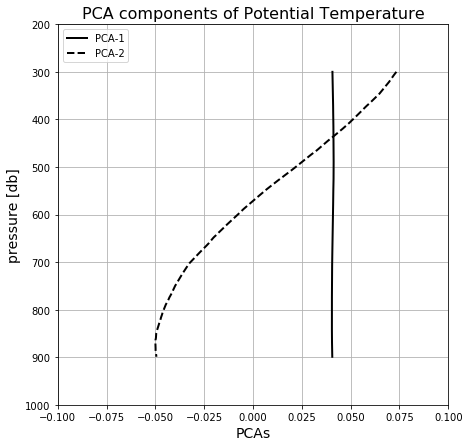

The Variance Explained computed by me for all the components is  99.9059962293
The Variance Explained computed by me for the first 2 modes of the original data is  98.971076169
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  7.61467713e-01   2.28067277e-01   6.95355424e-03   1.52265840e-03
   6.74513067e-04   3.37567036e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 6 PCs



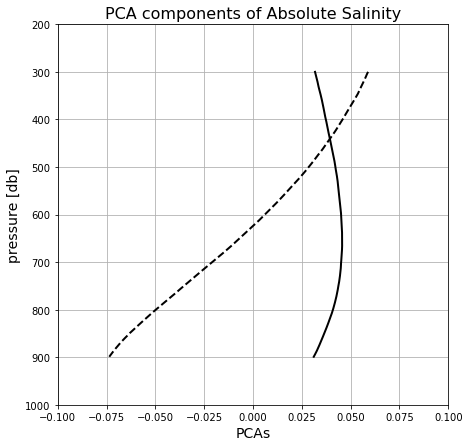

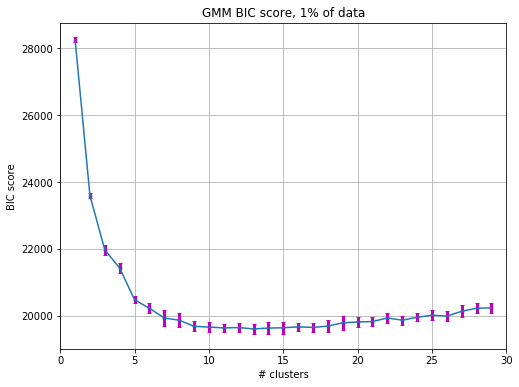

In [13]:
# test BIC score for a sub-sample of the training set
# If I don't want to show the print out nor the plots:
#old_stdout = sys.stdout
#sys.stdout = open(os.devnull, 'w')

run_PCM.test_small_sample_BIC(lon_dataSO,lat_dataSO,PT_dataSO,SA_dataSO,PTn,SAn,PTtr_r,SAtr_r,scalerPT,scalerSA,press,idz1,idz2,plotdir)

# I can start to print out again:
#sys.stdout = old_stdout

### 5. Classify the profiles using the Gaussian Mixture Model (GMM) as classifier: extract the parameters, labels and probabilities

In [14]:
# run the gmm of the training set
[labels_tr,post_tr,gmm]    = run_PCM.run_gmm(setTr_r,'',1,K)
# Classify the dataset:
[labels,post,gmm]          = run_PCM.run_gmm(set_r,gmm,0,K)

# extract the optimal parameters 
lambda_k               = gmm.weights_ 		# dimension = n_components = 9
mean_k                 = gmm.means_			# dimension = n_components x n_features = 9 x 4
cov_k                  = gmm.covariances_	# dimension = n_components x n_features x n_features = 9 x 4 x 4

### 6. Plot some maps

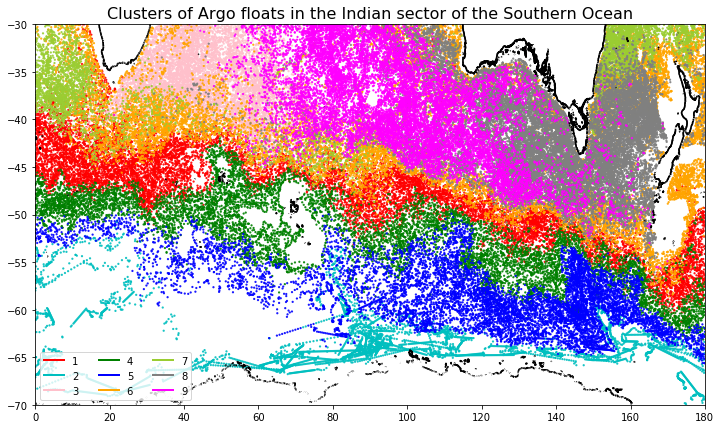

In [15]:
plot_maps.plot_clusters(labels,lon_dataSO,lat_dataSO,'T_S',K,bathy_data,plotdir)

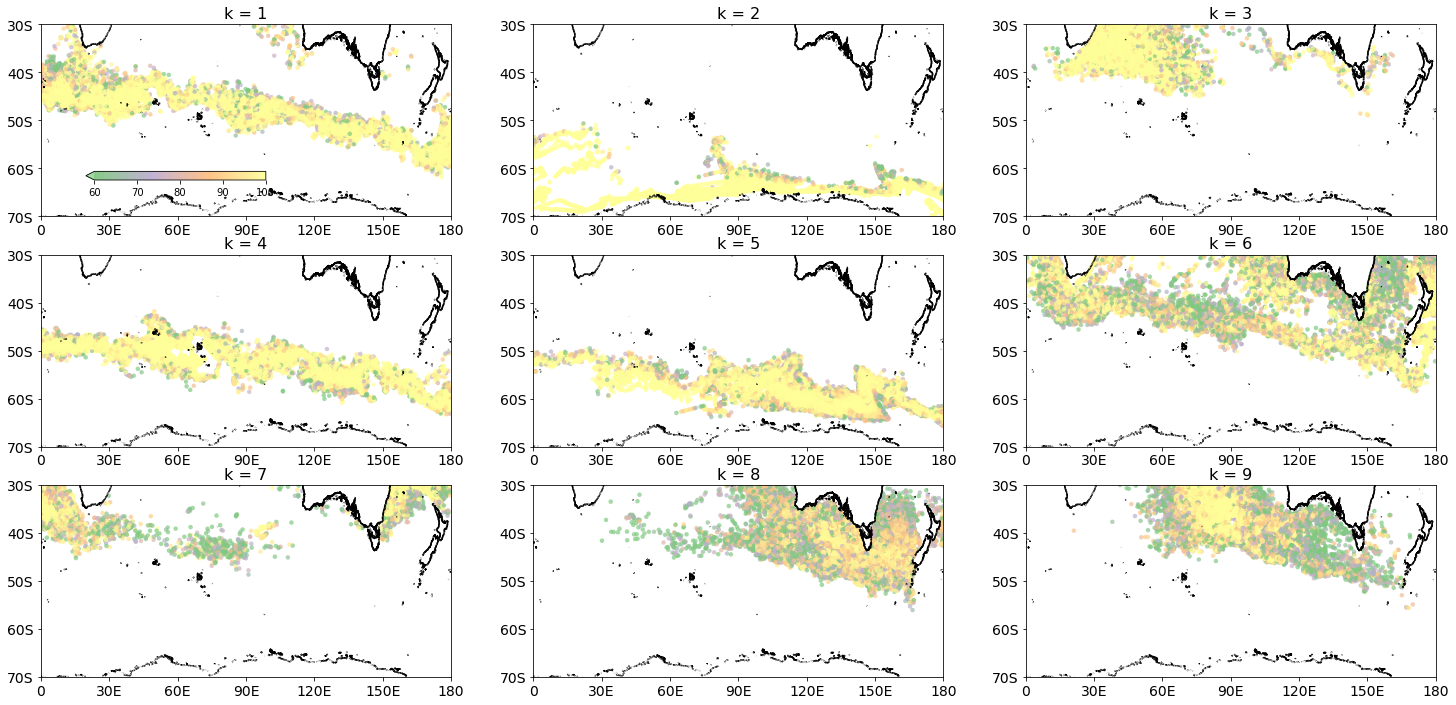

In [16]:
plot_maps.plot_map_prob(lon_dataSO,lat_dataSO,labels,post,K,bathy_data,'T_S',plotdir)

### plot total probabilities histograms

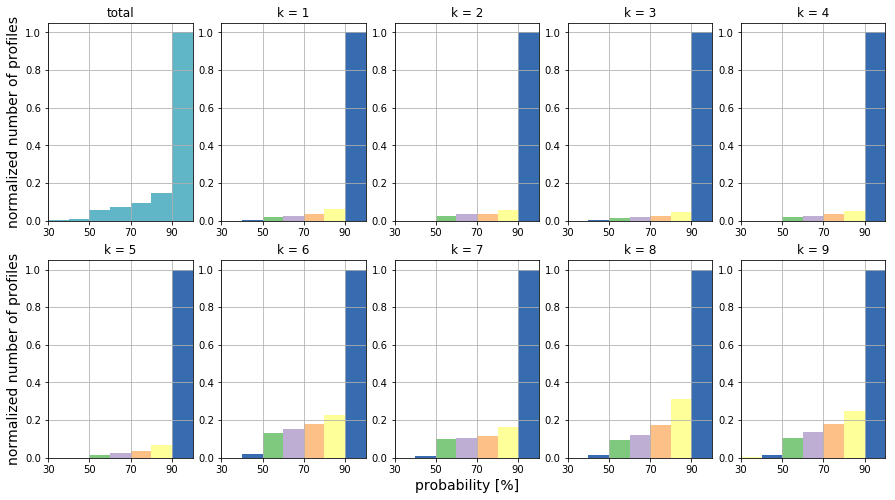

In [17]:
plot_maps.plot_histograms(labels,K,post,'T_S',plotdir)

### Plot fuzziness

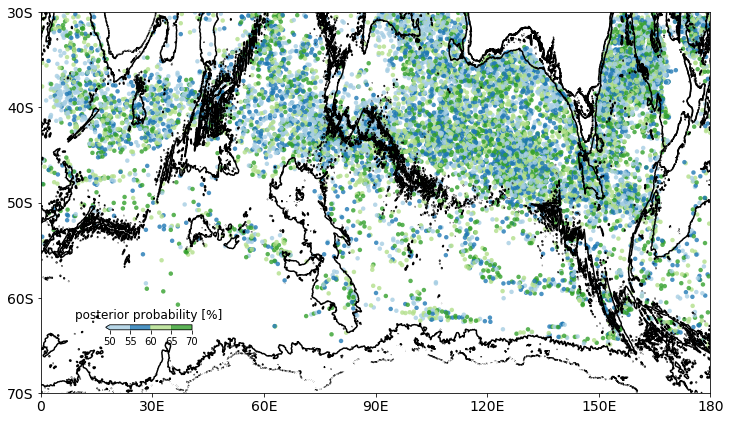

In [18]:
plot_maps.plot_fuzzy(K,lon_dataSO,lat_dataSO,labels,post,bathy_data,'T_S',plotdir)

## Repeat analysis for T and S combined: Q = [T S]

### Since we found that the cross-correlation between the 2 modes of T and S shows a not insignificant value, let's check what the combined field looks like

In [19]:
# combine T and S
Q       = np.zeros((PT_dataSO.shape[0],2*(idz2-idz1)),'>f4')
Q[:,:idz2-idz1] = PT_dataSO[:,idz1:idz2]
Q[:,idz2-idz1:] = SA_dataSO[:,idz1:idz2]

# normalize Q
scalerQ = preprocessing.StandardScaler()
scalerQ = scalerQ.fit(Q)
Qn      = scalerQ.transform(Q)

# extract training set using the rdm set defined before
Qn_tr   = Qn[rdm,:]
Qtr     = Q[rdm,:]

In [36]:
# build a new pressure array, with pressure levels repeated (since T and S are concatenated)
press2 = np.concatenate([press[idz1:idz2]]*2)
print 'The new pressure array has a dimension of',press2.shape[0]

# reduce the training set
[Nc_Q,V_Q,EOFs_Q,EOFs_real_Q,Qtr_r,reducerQ] = run_PCM.compute_PCA(Qn_tr,scalerQ,None,1,'Q = [T S]',press2,plotdir)
# reduce the full dataset:
[Nc_Q,V_Q,EOFs_Q,EOFs_real_Q,Q_r,reducerQ]   = run_PCM.compute_PCA(Qn,scalerQ,reducerQ,0,'Q = [T S]',press2,plotdir)

The new pressure array has a dimension of 1200
The Variance Explained computed by me for all the components is  99.9060663964
The Variance Explained computed by me for the first 2 modes of the original data is  96.5997685214
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  6.94726861e-01   2.71265084e-01   2.56593679e-02   4.34414464e-03
   1.52697953e-03   8.46476825e-04   4.38564691e-04   2.52987038e-04]

We reduced the dimensionality of the problem from 2000 depth levels down to 8 PCs

The Variance Explained computed by me for all the components is  99.9045639476
The Variance Explained computed by me for the first 2 modes of the original data is  96.508728159
The variance explained by each mode, computed by reducer.explained_variance_ratio_, is  [  6.94726861e-01   2.71265084e-01   2.56593679e-02   4.34414464e-03
   1.52697953e-03   8.46476825e-04   4.38564691e-04   2.52987038e-04]

We reduced the dimensionality of the problem from 2000 dept

In [37]:
print 'The first 3 modes explain', [6.94726861e-01 + 2.71265084e-01 + 2.56593679e-02],'of the variance.'
print 'The first 4 modes explain', [6.94726861e-01 + 2.71265084e-01 + 2.56593679e-02 + 4.34414464e-03],'of the variance.'

The first 3 modes explain [0.9916513129000001] of the variance.
The first 4 modes explain [0.9959954575400001] of the variance.


### The first 3 PCAs of Q explain 99% of the variance. Let's work with these first!

In [38]:
# 3 PCAs
# training
setTrQ_r = Qtr_r[:,:3]
# full
setQ_r   = Q_r[:,:3]

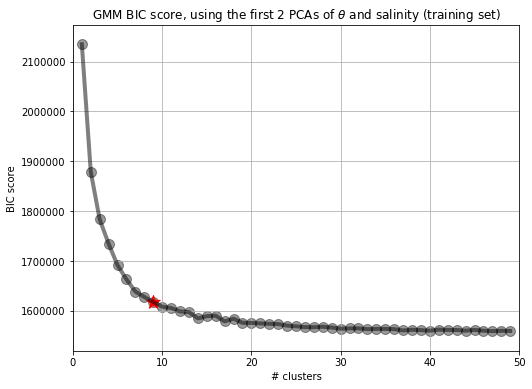

In [39]:
# plot the BIC
run_PCM.plot_BIC(setTrQ_r,'Q3',K,plotdir)

In [40]:
# run the gmm of the training set
[labels_Qtr,post_Qtr,gmmQ]    = run_PCM.run_gmm(setTrQ_r,'',1,K)
# Classify the dataset:
[labelsQ,postQ,gmmQ]          = run_PCM.run_gmm(setQ_r,gmmQ,0,K)

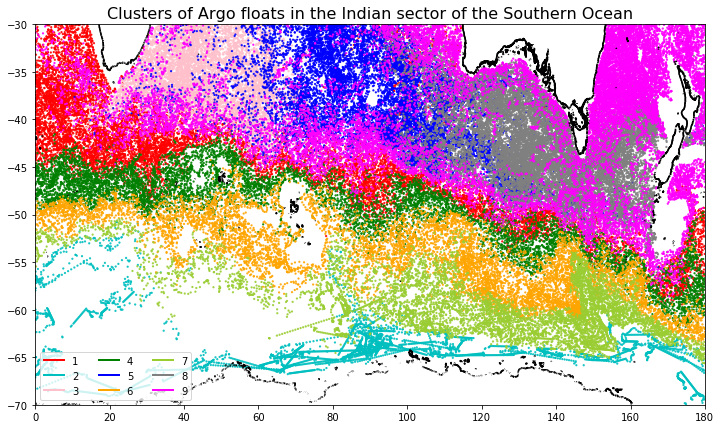

In [41]:
# plot the clusters
plot_maps.plot_clusters(labelsQ,lon_dataSO,lat_dataSO,'Q3',K,bathy_data,plotdir)

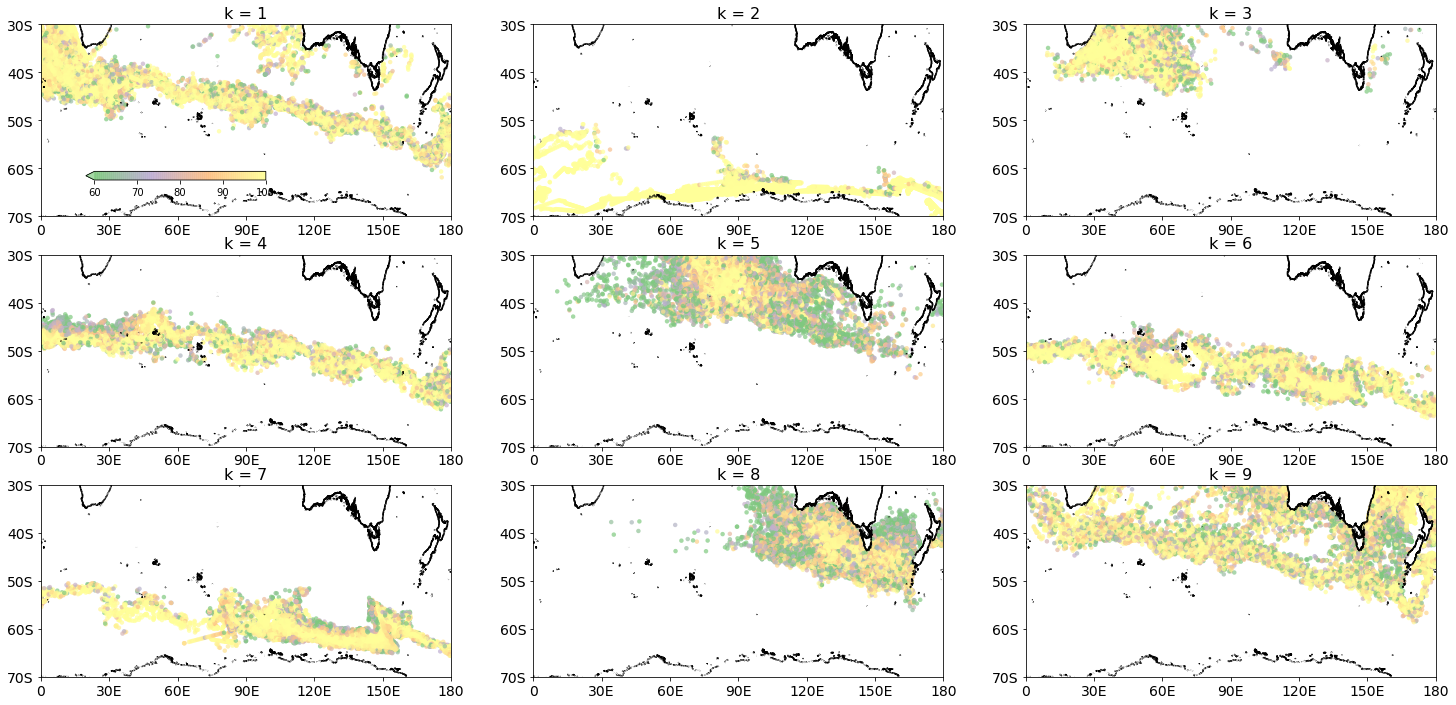

In [42]:
# map of clusters with post probab
plot_maps.plot_map_prob(lon_dataSO,lat_dataSO,labelsQ,postQ,K,bathy_data,'Q3',plotdir)

### The first 4 PCAs of Q explain 99.6% of the variance. Let's see what the result is with these modes..

In [43]:
# 4 PCAs
# training
setTrQ_r = Qtr_r[:,:4]
# full
setQ_r   = Q_r[:,:4]

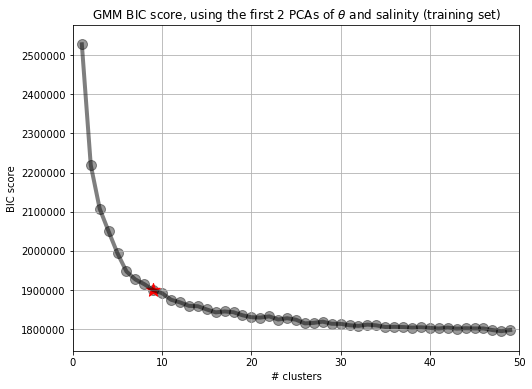

In [44]:
# plot the BIC
run_PCM.plot_BIC(setTrQ_r,'Q4',K,plotdir)

In [45]:
# run the gmm of the training set
[labels_Qtr,post_Qtr,gmmQ]    = run_PCM.run_gmm(setTrQ_r,'',1,K)
# Classify the dataset:
[labelsQ,postQ,gmmQ]          = run_PCM.run_gmm(setQ_r,gmmQ,0,K)

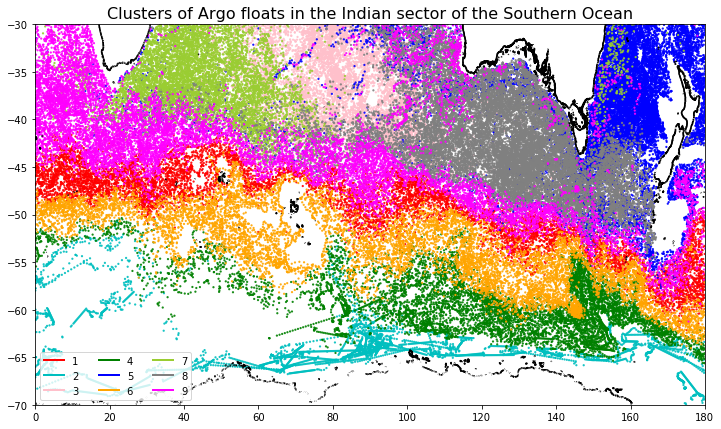

In [46]:
# plot the clusters
plot_maps.plot_clusters(labelsQ,lon_dataSO,lat_dataSO,'Q4',K,bathy_data,plotdir)

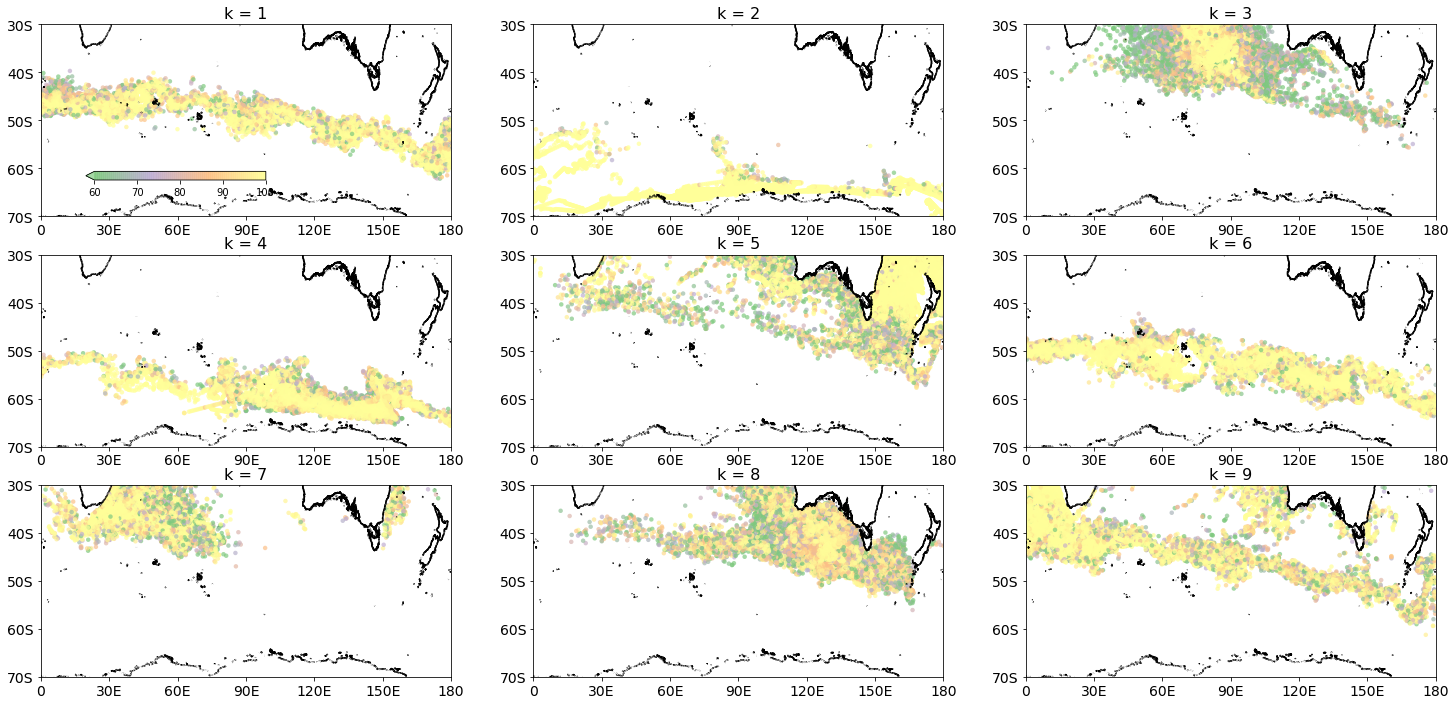

In [47]:
# map of clusters with post probab
plot_maps.plot_map_prob(lon_dataSO,lat_dataSO,labelsQ,postQ,K,bathy_data,'Q4',plotdir)